# Import Dependencies

In [ ]:
%pip install cdlib scikit-learn pandas plotly hvplot community python-louvain networkx

In [1]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import networkx as nx
from cdlib import algorithms, evaluation
import csv
import numpy as np
import pandas as pd
import os
import seaborn as sns

from sklearn.metrics import rand_score
from sklearn.metrics import adjusted_rand_score


from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.spatial import distance

from networkx.algorithms import approximation
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.centrality import closeness_centrality

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

from sklearn.metrics import pair_confusion_matrix
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

import colorsys


Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer', 'infomap', 'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer', 'infomap'}


# KEGG Network Formation

We employ the value-based construction with a delta of 0.85.

In [3]:
# NEW
file_path = "../dataset/sourced/kegg_ventures_cleaned.txt"
df = pd.read_csv(file_path, sep="\t")

# Extract relevant columns
genes = df["Gene"]
level_1_classes = df["Level_1"]
level_2_classes = df["Level_2"]
level_3_classes = df["Level_3"]
expression_data = df.iloc[:, 4:] # Extract time-series expression data

# Compute Pearson correlation matrix
correlation_matrix = np.corrcoef(expression_data)

# Threshold for value-based graph construction
delta = 0.85
# threshold = 1 - delta
# for precision, let's hardcode 0.15 here
adjacency_matrix = (correlation_matrix >= 0.15 ).astype(int)

# Create a graph
G = nx.Graph()

# Add nodes with Level 1 classification as attributes
for idx, gene in enumerate(genes):
    G.add_node(gene, level_1=level_1_classes[idx], level_2=level_2_classes[idx], level_3=level_3_classes[idx])

# Add edges based on Pearson correlation threshold
edges = []
for i in range(len(genes)):
    for j in range(i + 1, len(genes)):
        if adjacency_matrix[i, j] == 1:
            pearson_coefficient = correlation_matrix[i, j]
            G.add_edge(genes[i], genes[j], weight=pearson_coefficient)

# Remove singletons
singletons = list(nx.isolates(G))
G.remove_nodes_from(singletons)

print("Number of Nodes", len(G.nodes()))
print("Number of Edges", G.number_of_edges())
print("Transitivity", nx.transitivity(G))
print("Singletons Removed", len(singletons))

# # Old
# delta = 0.85

# Dataset = []

# # open and read a tab-separated values (TSV) file, storing the first 19 columns in dataset
# with open('../dataset/sourced/kegg_ventures_cleaned.txt') as tsv:
#     for line in csv.reader(tsv, dialect="excel-tab"):
#         Dataset.append(line[:21])

# # remove the header (if any) to ensure dataset contains only data
# Dataset = Dataset[1:]

# # calculates the number of nodes (n) based on the length of the dataset
# n = len(Dataset)
# print(n)

# # creates an empty Networkx graph G
# G = nx.Graph()

# # add nodes to the graph G, each with specific attributes derived from the dataset

# G.add_nodes_from([
#     (
#         i,  # node identifier, a unique number for each node
#         {
#             "label": Dataset[i][0],  # 'label' attribute, usually a name from the dataset
#             "group": Dataset[i][1:4],  # 'group' attribute, a category, converted to integer
#             "data": Dataset[i][4:]  # 'data' attribute, containing all remaining data points for the node

#         }
#     )
#     for i in range(n)  # loop through each item in the dataset, where 'n' is the total number of items
# ])

# # define edges between nodes based on specific conditions
# for i in range(n):
#     for j in range(i+1, n):

#         #print(G.nodes[i])
#         #print(G.nodes[j])

#         # convert the 'data' attribute of both nodes to float for calculations
#         x = [float(xi) for xi in G.nodes[i]["data"]]
#         y = [float(yi) for yi in G.nodes[j]["data"]]

#         # calculate distances and correlation coefficients between nodes
#         d = distance.euclidean(x,y)
#         m = distance.minkowski(x,y)
#         pearson = np.corrcoef(x,y)[0][1]
#         spearman, ps = spearmanr(x,y)
#         kendall, pk = kendalltau(x,y)

#         # add an edge if the Pearson correlation coefficient is above the threshold (delta)
#         if pearson>=delta:
#             G.add_edge(i,j, euc = d, mink= m, weight = pearson, spearman = spearman, kendall = kendall)

# # ------------------------------------------------------------

# Degree = dict(G.degree)
# nx.set_node_attributes(G, Degree, 'degree')
# print("Number of Nodes", len(G.nodes()))
# print("Number of Edges", G.number_of_edges())
# print("Transitivity", nx.transitivity(G))

# # calculate and print the average clustering coefficient
# print(approximation.average_clustering(G, trials=1000, seed=10))

# # identify connected components in the graph G and print their sizes and labels
# Connected_Components = [G.subgraph(c).copy() for c in nx.connected_components(G) if len(c)>1]

# # used to keep track of the size of the largest connected component found so far
# max = -1

# # store the actual connected component that is the largest
# BigC = []

# # if the size (len(c)) of the current component c is greater than the current max
# # update max with the new larger size
# # and update BigC to be this current component.

# for c in Connected_Components:
#     if len(c) > max:
#         max = len(c)
#         BigC = c

# # printing the size of the largest connected component
# print("Max Component with", len(BigC))

# nx.set_node_attributes(G, -1, 'gn_grp')

# # ------------------------------------------------------------

# # total number of nodes in the original graph before removing singletons
# original_node_count = G.number_of_nodes()

# # create a subgraph that contains only nodes in connected components
# subG = nx.compose_all(Connected_Components)

# # total number of nodes in the subgraph after removing singletons
# subgraph_node_count = subG.number_of_nodes()

# # calculate and print the number of singletons removed
# singletons_removed = original_node_count - subgraph_node_count
# print(f"Number of singletons removed: {singletons_removed}")

Number of Nodes 242
Number of Edges 13149
Transitivity 0.779512645024918
Singletons Removed 0


## KEGG Network Visualization (Level 1 Functions)

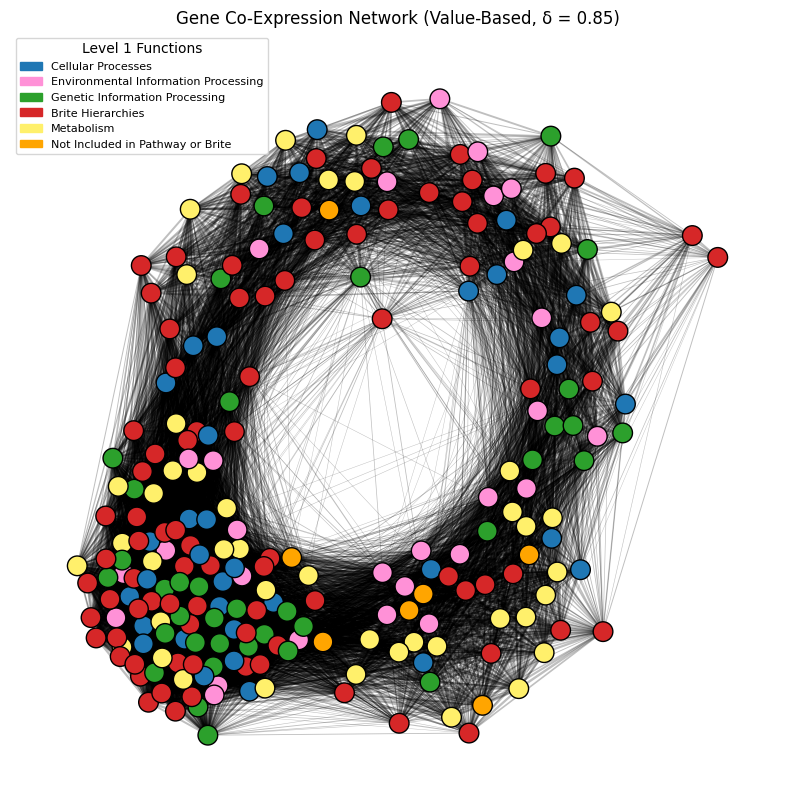

In [ ]:
# NEW
TABLEAU_COLORS = {
    'tab:blue': '#1f77b4',
    'tab:pink': '#ff91d7',
    'tab:green': '#2ca02c',
    'tab:red': '#d62728',
    'tab:yellow': '#fff06b',
    'tab:orange': '#ffa500'
}
# Define unique colors for each Level 1 function
unique_classes = level_1_classes.unique()
color_map = {cls: TABLEAU_COLORS[list(TABLEAU_COLORS.keys())[i]] for i, cls in enumerate(unique_classes)}

# Assign colors to nodes based on Level 1 function
node_colors = [color_map[G.nodes[n]["level_1"]] for n in G.nodes()]

# Edge weights for visualization (stronger edges appear tighter)
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Generate graph layout
plt.figure(figsize=(10, 10))
level_1_functions = ["Metabolism", "Genetic Information Processing", "Environmental Information Processing", "Cellular Processes", "Brite Hierarchies", "Not Included in Pathway or Brite"]
legend_handles = [Patch(color=color, label=f'{level_1_functions[cls-1]}') for cls, color in color_map.items()]
plt.legend(handles=legend_handles, loc="best", fontsize=8, title="Level 1 Functions")
pos = nx.spring_layout(G, weight='weight', k=0.1, seed=10)  # Spring layout based on weights

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, alpha=1, edgecolors="black")

# Draw edges with thickness based on weight
nx.draw_networkx_edges(G, pos, alpha=0.25, edge_color="black", width=[w * 2 for w in edge_weights])

# Show plot
plt.title(f"Gene Co-Expression Network (Value-Based, δ = {delta})")
plt.axis("off")
plt.show()


# OLD
# create a color map, one color for each component
# components = list(nx.connected_components(subG))
# color_map = {}
# for i, component in enumerate(components):
#     for node in component:
#         color_map[node] = i
# colors = [color_map[node] for node in subG.nodes()]

# pos = nx.spring_layout(subG)

# # draw the graph
# plt.figure(figsize=(12, 10))
# nodes = nx.draw_networkx_nodes(subG, pos, alpha=0.8, node_color=colors, cmap=plt.get_cmap('viridis'))
# nx.draw_networkx_edges(subG, pos, alpha=0.5, edge_color='gray')

# # create a legend
# # generate a color for each component using the same colormap and normalization
# cmap = plt.get_cmap('viridis')
# norm = plt.Normalize(0, len(components))
# legend_colors = [cmap(norm(i)) for i in range(len(components))]  # Generate legend colors

# # Create a legend with a color box for each component
# legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"Community {i+1}",
#                           markerfacecolor=legend_colors[i], markersize=10) for i in range(len(components))]

# plt.title('KEGG Network Formation')
# plt.axis('off')
# plt.legend(handles=legend_elements, title='Communities', bbox_to_anchor=(1, 1))




# plt.show()

## KEGG Network Visualization (Level 2 Functions)

In [ ]:
## TODO: Implement visualization for level 2 of KEGG dataset

## KEGG Network Visualization (Level 3 Functions)

In [ ]:
## TODO: Implement visualization for level 3 of KEGG dataset

# Community Detection Auxiliary Functions

These are the functions used during the Community Detection of our constructed network.

In [ ]:
def visualize_community(G, communities, title, output_dir, file_name, save_file=False):
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G)  # Recalculate layout to ensure all nodes are included

    cmap = plt.get_cmap('viridis', len(communities))

    for i, community in enumerate(communities):
        if community:  # Check if community is not empty
            # Filter out nodes not present in the graph
            valid_nodes = [node for node in community if node in G]
            nx.draw_networkx_nodes(G, pos, nodelist=valid_nodes, node_color=[cmap(i)], alpha=0.8)

    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    legend_handles = [mpatches.Patch(color=cmap(i), label=f'Community {i + 1}') for i in range(len(communities))]
    plt.legend(handles=legend_handles, loc='upper left', title="Communities")
    plt.title(f"{title} Algorithm Communities")
    plt.axis('off')
    plt.tight_layout()
    if save_file:
        plt.savefig(f"{output_dir}/{file_name}_{title}.png", bbox_inches="tight")
    plt.show()

In [18]:
def visualize_disconnected_communities(G, communities, color_map, title="Paris Algorithm Communities"):
    """
    Visualizes detected communities as separate disconnected subgraphs while keeping Level 1 colors.

    Parameters:
    - G: NetworkX graph
    - communities: CDLib NodeClustering object (Paris, Infomap, Louvain, etc.)
    - color_map: Dictionary mapping Level 1 categories to colors
    - title: Title for the plot
    """

    # Define layout positioning for separate communities
    num_communities = len(communities.communities)
    fig, ax = plt.subplots(figsize=(12, 8))

    # Generate separate layouts for each community
    layouts = []
    for i in range(num_communities):
        layouts.append(nx.spring_layout(G.subgraph(communities.communities[i]), seed=42))

    # Normalize layout positions to avoid overlap
    spacing = 3
    for i, layout in enumerate(layouts):
        for node in layout:
            layout[node] += [i * spacing, 0]  # Shift positions to separate communities

    # Draw each community separately
    for i, community in enumerate(communities.communities):
        subG = G.subgraph(community)
        pos = layouts[i]

        # Assign Level 1 colors
        node_colors = [color_map[G.nodes[n]["level_1"]] for n in subG.nodes()]

        # Draw nodes
        nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=200, alpha=1, edgecolors="black")

        # Draw edges
        nx.draw_networkx_edges(subG, pos, alpha=0.3, edge_color="black")

    # Create a legend for Level 1 classification
    level_1_functions = ["Metabolism", "Genetic Information Processing", "Environmental Information Processing", "Cellular Processes", "Brite Hierarchies", "Not Included in Pathway or Brite"]
    legend_handles = [Patch(color=color, label=f'{level_1_functions[cls-1]}') for cls, color in color_map.items()]
    plt.legend(handles=legend_handles, loc="best", fontsize=8, title="Level 1 Functions")

    # Display
    plt.title(title)
    plt.axis("off")
    plt.show()


In [6]:
import itertools

def modified_rand_score(labels_true, labels_pred, nodes_true_list, nodes_pred_list):
    """
    Compute the Modified Rand Index (MRI), an extension of the Rand Index
    that accounts for missing elements between partitions.

    Parameters
    ----------
    labels_true : list
        True labels corresponding to the nodes.
    labels_pred : list
        Predicted labels corresponding to the nodes.
    nodes_true_list : list
        An ordered list of nodes corresponding to labels_true.
    nodes_pred_list : list
        An ordered list of nodes corresponding to labels_pred.

    Returns
    -------
    mri : float
        The Modified Rand Index score.
    """

    n = len(labels_true)
    total_pairs = n * (n - 1) // 2  # All possible unique node pairs
    n_00, n_11, n_xx = 0, 0, 0  # Initialize counts

    # Convert lists to sets for fast lookup
    nodes_true_set = set(nodes_true_list)
    nodes_pred_set = set(nodes_pred_list)

    # Identify common nodes between the two partitions
    common_nodes = nodes_true_set.intersection(nodes_pred_set)

    # Iterate over all node pairs
    for i, j in itertools.combinations(range(n), 2):  # Iterate over all unique pairs
        node_i, node_j = nodes_true_list[i], nodes_true_list[j]

        # If either node is missing from the common set, count this pair as n_xx.
        if node_i not in common_nodes or node_j not in common_nodes:
            n_xx += 1
        else:
            same_true = (labels_true[i] == labels_true[j])
            same_pred = (labels_pred[i] == labels_pred[j])
            if same_true and same_pred:
                n_11 += 1  # Agreeing pair (same in both)
            elif not same_true and not same_pred:
                n_00 += 1  # Agreeing pair (different in both)

    # Compute MRI Score
    if total_pairs == 0:
        return 1.0  # Perfect match in trivial cases

    MRI = (n_00 + n_11 + n_xx) / total_pairs
    return MRI


# Hierarchical Community Detection

Using our formed network, we employ the Paris and LFM algorithms.

## Prepare Directory and Dataframe

In [ ]:
# output_dir = "Paris - Graphs"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# Paris_results = pd.DataFrame(columns=[
#     "Number of Communities",
#     "Nodes in Largest Community",
#     "Community Sizes",
#     "Singletons",
#     "Modularity",
#     "Closeness Centrality",
#     "ARI (Level 1)",
#     "ARI (Level 2)",
#     "RI (Level 1)",
#     "RI (Level 2)",
#     "MRI (Level 1)",
#     "MRI (Level 2)",
#     "Communities",
#     ])

## Apply Paris Algorithm and Criteria

In [12]:
# NEW
paris_communities = algorithms.paris(G)

# Compute required metrics
num_communities = len(paris_communities.communities)
largest_community_size = max(len(c) for c in paris_communities.communities)
community_sizes = [len(c) for c in paris_communities.communities]
num_singletons = sum(1 for c in paris_communities.communities if len(c) == 1)
modularity_score = evaluation.newman_girvan_modularity(G, paris_communities).score
closeness_centrality = np.mean(list(nx.closeness_centrality(G).values()))

predicted_labels_dict = {node: -1 for node in G.nodes()}
for i, community in enumerate(paris_communities.communities):
    for node in community:
        predicted_labels_dict[node] = i
predicted_labels = [predicted_labels_dict[node] for node in G.nodes()]

node_to_community = {node: idx for idx, community in enumerate(paris_communities.communities) for node in community}
true_labels_level_1 = [G.nodes[n]["level_1"] for n in G.nodes()]
true_labels_level_2 = [G.nodes[n]["level_2"] for n in G.nodes()]
true_labels_level_3 = [G.nodes[n]["level_3"] for n in G.nodes()]

# ARI calculation
ari_classifications_score1 = adjusted_rand_score(true_labels_level_1, predicted_labels)
ari_classifications_score2 = adjusted_rand_score(true_labels_level_2, predicted_labels)
ari_classifications_score3 = adjusted_rand_score(true_labels_level_3, predicted_labels)

# RI calculation
ri_classifications_score1 = rand_score(true_labels_level_1, predicted_labels)
ri_classifications_score2 = rand_score(true_labels_level_2, predicted_labels)
ri_classifications_score3 = rand_score(true_labels_level_3, predicted_labels)

# MRI calculation
nodes_true_list = list(G.nodes())
nodes_pred_list = list(node for community in paris_communities.communities for node in community)
mri_classifications_score1 = modified_rand_score(true_labels_level_1, predicted_labels, nodes_true_list, nodes_pred_list)
mri_classifications_score2 = modified_rand_score(true_labels_level_2, predicted_labels, nodes_true_list, nodes_pred_list)
mri_classifications_score3 = modified_rand_score(true_labels_level_3, predicted_labels, nodes_true_list, nodes_pred_list)

Paris_results = pd.DataFrame({
    "Number of Communities": [num_communities],
    "Nodes in Largest Community": [largest_community_size],
    "Community Sizes": [community_sizes],
    "Singletons": [num_singletons],
    "Modularity": [modularity_score],
    "Closeness Centrality": [closeness_centrality],
    "ARI (Level 1)": [ari_classifications_score1],
    "ARI (Level 2)": [ari_classifications_score2],
    "ARI (Level 3)": [ari_classifications_score3],
    "RI (Level 1)": [ri_classifications_score1],
    "RI (Level 2)": [ri_classifications_score2],
    "RI (Level 3)": [ri_classifications_score3],
    "MRI (Level 1)": [mri_classifications_score1],
    "MRI (Level 2)": [mri_classifications_score2],
    "MRI (Level 3)": [mri_classifications_score3],
    "Communities": [paris_communities.communities]
})
output_dir = "Paris - Graphs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
Paris_results.to_csv(f"{output_dir}/Paris_Results_Kegg.csv")
Paris_results

# OLD
# Assuming subG is your graph object and it's already defined
# TODO: Figure out how to remove cycles from the subG graph
# paris_clusters = algorithms.paris(G)

# # true labels for ARI calculation
# true_labels1 = [subG.nodes[n]["group"][0] for n in subG.nodes()]
# true_labels2 = [subG.nodes[n]["group"][1] for n in subG.nodes()]

# # prepare predicted_labels for ARI calculation
# predicted_labels_dict = {node: -1 for node in subG.nodes()}
# for i, community in enumerate(paris_clusters.communities):
#     for node in community:
#         predicted_labels_dict[node] = i
# predicted_labels_list = [predicted_labels_dict[node] for node in subG.nodes()]

# # ARI calculation
# ari_classifications_score1 = adjusted_rand_score(true_labels1, predicted_labels_list)
# ari_classifications_score2 = adjusted_rand_score(true_labels2, predicted_labels_list)

# # RI calculation
# ri_classifications_score1 = rand_score(true_labels1, predicted_labels_list)
# ri_classifications_score2 = rand_score(true_labels2, predicted_labels_list)

# # MRI calculation
# nodes_true_list = list(subG.nodes())  # List of nodes in the true partition
# nodes_pred_list = list(node for community in paris_clusters.communities for node in community)  # List of nodes in the predicted partition
# mri_classifications_score1 = modified_rand_score(true_labels1, predicted_labels_list, nodes_true_list, nodes_pred_list)
# mri_classifications_score2 = modified_rand_score(true_labels2, predicted_labels_list, nodes_true_list, nodes_pred_list)

# num_communities = len(paris_clusters.communities)
# community_list = [list(community) for community in paris_clusters.communities]
# community_sizes = [len(community) for community in paris_clusters.communities]

# # find the largest community size
# largest_community_size = 0
# for community in paris_clusters.communities:
#     if len(community) > largest_community_size:
#         largest_community_size = len(community)

# num_singletons = community_sizes.count(1)

# # Modularity score for Paris clusters
# modularity_score = evaluation.newman_girvan_modularity(subG, paris_clusters).score

# # Create subgraph using Paris clusters
# subgraph = subG.subgraph([node for community in paris_clusters.communities for node in community])

# # Calculate closeness centrality for all nodes in the subgraph
# centrality_score = nx.closeness_centrality(subgraph)

# # Calculate the overall closeness centrality score as the average of all node scores
# overall_centrality_score = sum(centrality_score.values()) / len(centrality_score)

# Paris_results.loc[0] = [
#     num_communities, 
#     largest_community_size, 
#     str(community_sizes), 
#     num_singletons, 
#     modularity_score, 
#     overall_centrality_score, 
#     ari_classifications_score1, 
#     ari_classifications_score2, 
#     ri_classifications_score1, 
#     ri_classifications_score2,
#     mri_classifications_score1,
#     mri_classifications_score2,
#     community_list]

# # visualization function call
# visualize_community(subG, paris_clusters.communities, 'Paris', output_dir, 'Paris_Communities', save_file=False)

# plt.close()

# Paris_results.to_csv(f"{output_dir}/Paris_Results_Kegg.csv")

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),ARI (Level 2),ARI (Level 3),RI (Level 1),RI (Level 2),RI (Level 3),MRI (Level 1),MRI (Level 2),MRI (Level 3),Communities
0,3,92,"[92, 87, 63]",0,0.344075,0.631397,-0.000582,0.017928,0.015286,0.588629,0.626899,0.651075,0.588629,0.626899,0.651075,"[[83, 71, 78, 178, 174, 59, 43, 73, 56, 156, 7..."


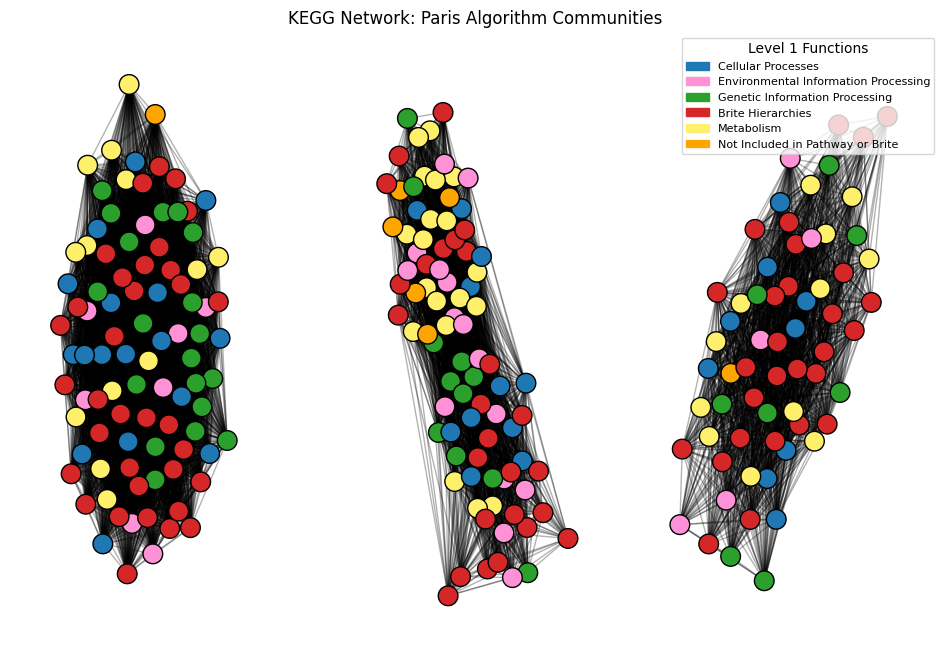

In [20]:
visualize_disconnected_communities(G, paris_communities, color_map, title="KEGG Network: Paris Algorithm Communities")

# Dynamic Community Detection
Using our formed network, we employ the Infomap and TILES algorithms.

## Prepare Directory and Dataframe

In [ ]:
output_dir = "Infomap - Graphs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Infomap_results = pd.DataFrame(columns=[
    "Number of Communities",
    "Nodes in Largest Community",
    "Community Sizes",
    "Singletons",
    "Modularity",
    "Closeness Centrality",
    "ARI (Level 1)",
    "ARI (Level 2)",
    "RI (Level 1)",
    "RI (Level 2)",
    "MRI (Level 1)",
    "MRI (Level 2)",
    "Communities",
    ])

## Apply Infomap Algorithm and Criteria

In [24]:
# NEW
infomap_communities = algorithms.infomap(G)

def evaluate_infomap():
	# Compute required metrics
	num_communities = len(infomap_communities.communities)
	largest_community_size = max(len(c) for c in infomap_communities.communities)
	community_sizes = [len(c) for c in infomap_communities.communities]
	num_singletons = sum(1 for c in infomap_communities.communities if len(c) == 1)
	modularity_score = evaluation.newman_girvan_modularity(G, infomap_communities).score
	closeness_centrality = np.mean(list(nx.closeness_centrality(G).values()))

	predicted_labels_dict = {node: -1 for node in G.nodes()}
	for i, community in enumerate(infomap_communities.communities):
			for node in community:
					predicted_labels_dict[node] = i
	predicted_labels = [predicted_labels_dict[node] for node in G.nodes()]


	node_to_community = {node: idx for idx, community in enumerate(infomap_communities.communities) for node in community}
	true_labels_level_1 = [G.nodes[n]["level_1"] for n in G.nodes()]
	true_labels_level_2 = [G.nodes[n]["level_2"] for n in G.nodes()]
	true_labels_level_3 = [G.nodes[n]["level_3"] for n in G.nodes()]

	# ARI calculation
	ari_classifications_score1 = adjusted_rand_score(true_labels_level_1, predicted_labels)
	ari_classifications_score2 = adjusted_rand_score(true_labels_level_2, predicted_labels)
	ari_classifications_score3 = adjusted_rand_score(true_labels_level_3, predicted_labels)

	# RI calculation
	ri_classifications_score1 = rand_score(true_labels_level_1, predicted_labels)
	ri_classifications_score2 = rand_score(true_labels_level_2, predicted_labels)
	ri_classifications_score3 = rand_score(true_labels_level_3, predicted_labels)

	# MRI calculation
	nodes_true_list = list(G.nodes())
	nodes_pred_list = list(node for community in infomap_communities.communities for node in community)
	mri_classifications_score1 = modified_rand_score(true_labels_level_1, predicted_labels, nodes_true_list, nodes_pred_list)
	mri_classifications_score2 = modified_rand_score(true_labels_level_2, predicted_labels, nodes_true_list, nodes_pred_list)

	Infomap_results = pd.DataFrame({
			"Number of Communities": [num_communities],
			"Nodes in Largest Community": [largest_community_size],
			"Community Sizes": [community_sizes],
			"Singletons": [num_singletons],
			"Modularity": [modularity_score],
			"Closeness Centrality": [closeness_centrality],
			"ARI (Level 1)": [ari_classifications_score1],
			"ARI (Level 2)": [ari_classifications_score2],
			"ARI (Level 3)": [ari_classifications_score3],
			"RI (Level 1)": [ri_classifications_score1],
			"RI (Level 2)": [ri_classifications_score2],
			"RI (Level 3)": [ri_classifications_score3],
			"MRI (Level 1)": [mri_classifications_score1],
			"MRI (Level 2)": [mri_classifications_score2],
			"MRI (Level 3)": [mri_classifications_score3],
			"Communities": [infomap_communities.communities]
	})
	return Infomap_results

Infomap_results = evaluate_infomap()

Infomap_results.to_csv(f"{output_dir}/Infomap_Results_Kegg.csv")
# OLD
# Assuming subG is your graph object and it's already defined
# infomap_clusters = algorithms.infomap(subG)

# # true labels for ARI calculation
# true_labels1 = [subG.nodes[n]["group"][0] for n in subG.nodes()]
# true_labels2 = [subG.nodes[n]["group"][1] for n in subG.nodes()]

# # prepare predicted_labels for ARI calculation
# predicted_labels_dict = {node: -1 for node in subG.nodes()}
# for i, community in enumerate(infomap_clusters.communities):
#     for node in community:
#         predicted_labels_dict[node] = i
# predicted_labels_list = [predicted_labels_dict[node] for node in subG.nodes()]

# # ARI calculation
# ari_classifications_score1 = adjusted_rand_score(true_labels1, predicted_labels_list)
# ari_classifications_score2 = adjusted_rand_score(true_labels2, predicted_labels_list)

# # RI calculation
# ri_classifications_score1 = rand_score(true_labels1, predicted_labels_list)
# ri_classifications_score2 = rand_score(true_labels2, predicted_labels_list)

# # MRI calculation
# nodes_true_list = list(subG.nodes())  # List of nodes in the true partition
# nodes_pred_list = list(node for community in infomap_clusters.communities for node in community)  # List of nodes in the predicted partition
# mri_classifications_score1 = modified_rand_score(true_labels1, predicted_labels_list, nodes_true_list, nodes_pred_list)
# mri_classifications_score2 = modified_rand_score(true_labels2, predicted_labels_list, nodes_true_list, nodes_pred_list)

# num_communities = len(infomap_clusters.communities)
# community_list = [list(community) for community in infomap_clusters.communities]
# community_sizes = [len(community) for community in infomap_clusters.communities]

# # find the largest community size
# largest_community_size = 0
# for community in infomap_clusters.communities:
#     if len(community) > largest_community_size:
#         largest_community_size = len(community)

# num_singletons = community_sizes.count(1)

# # Modularity score for Infomap clusters
# modularity_score = evaluation.newman_girvan_modularity(subG, infomap_clusters).score

# # Create subgraph using Infomap clusters
# subgraph = subG.subgraph([node for community in infomap_clusters.communities for node in community])

# # Calculate closeness centrality for all nodes in the subgraph
# centrality_score = nx.closeness_centrality(subgraph)

# # Calculate the overall closeness centrality score as the average of all node scores
# overall_centrality_score = sum(centrality_score.values()) / len(centrality_score)

# Infomap_results.loc[0] = [
#     num_communities, 
#     largest_community_size, 
#     str(community_sizes), 
#     num_singletons, 
#     modularity_score, 
#     overall_centrality_score, 
#     ari_classifications_score1, 
#     ari_classifications_score2, 
#     ri_classifications_score1, 
#     ri_classifications_score2,
#     mri_classifications_score1,
#     mri_classifications_score2,
#     community_list
#     ]

# # visualization function call
# visualize_community(subG, infomap_clusters.communities, 'Infomap', output_dir, 'Infomap_Communities', save_file=False)

# plt.close()

Infomap_results.to_csv(f"{output_dir}/Infomap_Results_Kegg.csv")
Infomap_results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),ARI (Level 2),ARI (Level 3),RI (Level 1),RI (Level 2),RI (Level 3),MRI (Level 1),MRI (Level 2),MRI (Level 3),Communities
0,1,242,[242],0,3.996803e-15,0.631397,0.0,0.0,0.0,0.224341,0.127499,0.048181,0.224341,0.127499,0.651075,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
